# **Predict Median House Values in Californian Districts**

*This project uses California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California. The model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.*

*This is the project in chapter 2 in the book "Hands-on  Machine Learning   with Scikit-Learn,  Keras & TensorFlow ".*

## **Import Libraries** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from scipy import stats 
import joblib

## **Get The Data**

In [2]:
df = pd.read_csv("housing.csv")

## **Data Exploration**

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# Explore the numerical variables
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
# Explore the categorical variable
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

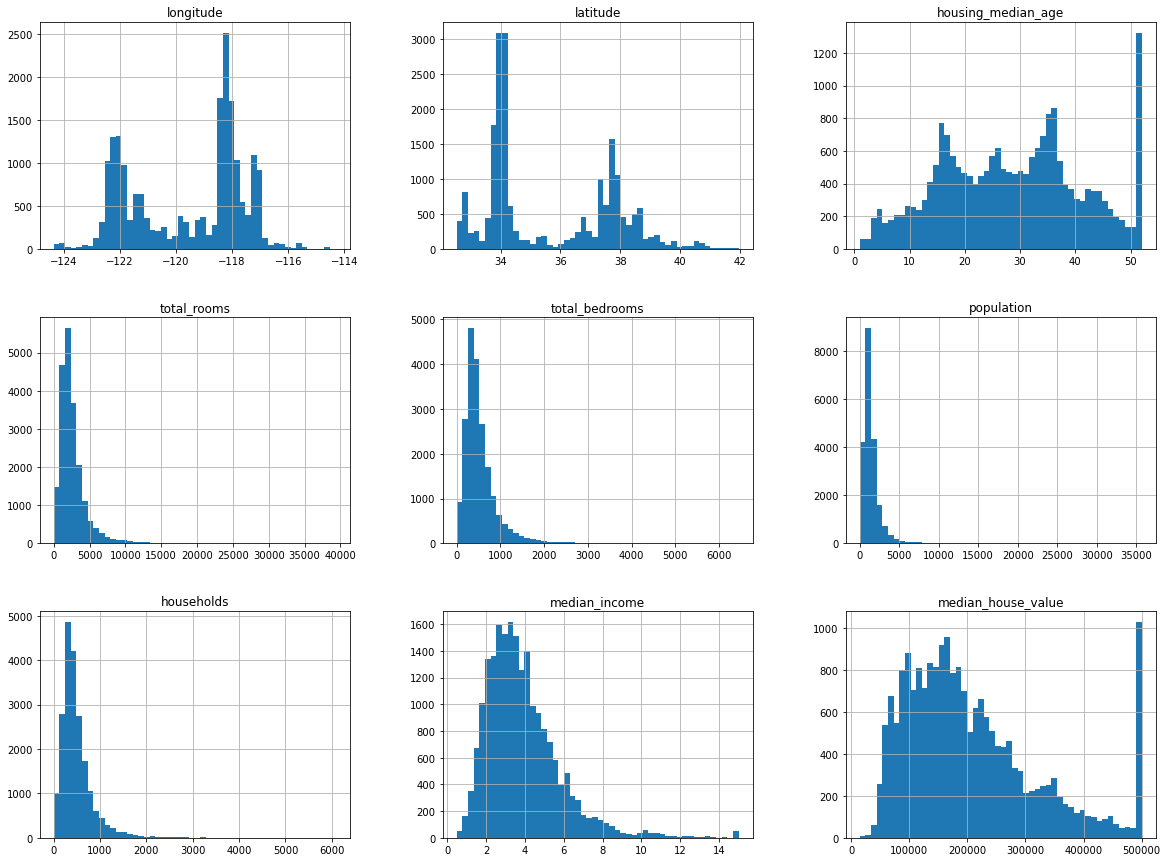

In [7]:
# Numerical values distributions
df.hist(bins=50,figsize=(20,15));

## **Train Test Split**

The purpose of this step is to split the test set and keep it aside.

In this dataset, the "median income" variable is a very important attribute to predict median housing prices. So, it is important for the test set to be representative of the various categories of incomes in the whole dataset. So, stratified sampling is used to split the test data.

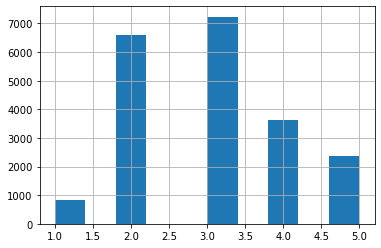

In [8]:
df["income_categ"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
df["income_categ"].hist();

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(df, df["income_categ"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index] 

In [10]:
# difference between income category proportions in overall dataset and in test set with stratified sampling
(test_set["income_categ"].value_counts() / len(test_set)) - (df["income_categ"].value_counts() / len(df))

3   -0.000048
2   -0.000048
4    0.000048
5   -0.000097
1    0.000145
Name: income_categ, dtype: float64

In [11]:
train_set.drop("income_categ", axis=1, inplace=True)
test_set.drop("income_categ", axis=1, inplace=True)

# **Discover and Visualize the Data**

In [12]:
temp = train_set.copy()

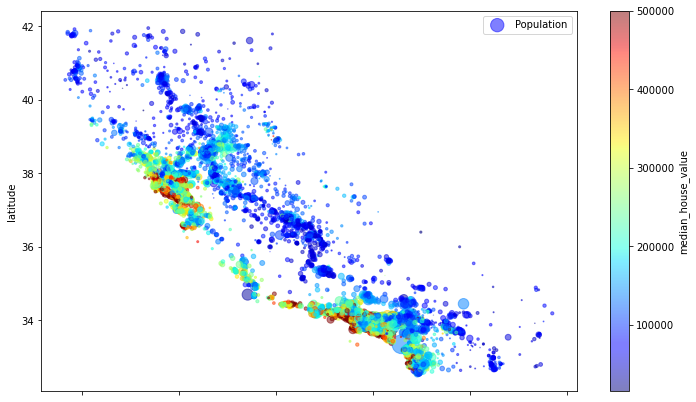

In [13]:
# The radius of each circle represents the population, and the color represents the price
temp.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, s=temp["population"]/100,
         label="Population", figsize=(12,7), c="median_house_value",  cmap=plt.get_cmap("jet"),
         colorbar=True)
plt.legend();

## **Looking For Correlations**

In [14]:
corr_matrix = temp.corr()
corr_matrix["median_house_value"].sort_values(ascending=False) 

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

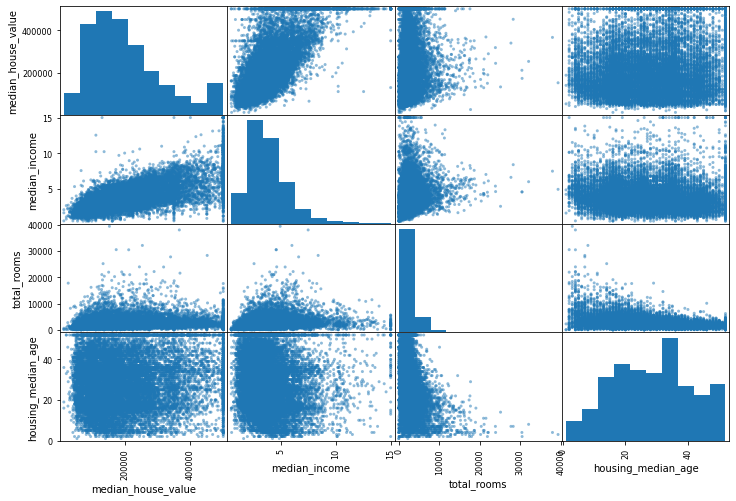

In [15]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
pd.plotting.scatter_matrix(temp[attributes], figsize=(12, 8));

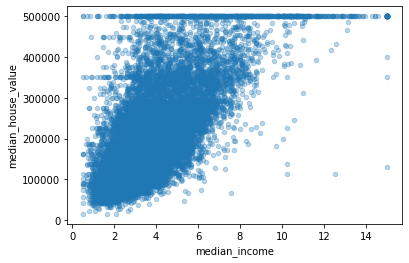

In [16]:
temp.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.3);

## **Data Preparation**

In [17]:
housing = train_set.drop("median_house_value", axis=1) 
housing_labels = train_set["median_house_value"].copy()
housing_num = housing.drop("ocean_proximity", axis=1)
housing_cat = housing[["ocean_proximity"]] 

In [18]:
num_pipeline = Pipeline([        
    ('imputer', SimpleImputer(strategy="median")),              
    ('std_scaler', StandardScaler())
])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([        
    ("num", num_pipeline, num_attribs),        
    ("cat", OneHotEncoder(), cat_attribs)  
])

housing_prepared = full_pipeline.fit_transform(housing) 

## **Select and Train a Model**

In [19]:
linReg = LinearRegression()
linReg.fit(housing_prepared, housing_labels)
housing_predictions = linReg.predict(housing_prepared) 
linMSE = mean_squared_error(housing_labels, housing_predictions) 
linRMSE = np.sqrt(linMSE) 
print(f"Linear Regression Root Mean Square Error: {linRMSE}")

Linear Regression Root Mean Square Error: 69050.56219504567


**The Linear Regression model is underfitting the data. So, a more powerful model should be selected**

In [20]:
treeReg = DecisionTreeRegressor() 
treeReg.fit(housing_prepared, housing_labels) 
housing_predictions = treeReg.predict(housing_prepared)
treeRMSE = mean_squared_error(housing_labels, housing_predictions) 
treeRMSE = np.sqrt(treeRMSE)  
print(f"Decision Tree Root Mean Square Error: {treeRMSE}")

Decision Tree Root Mean Square Error: 0.0


**The Decision Tree model is probably overfitting the data. So, we use validation set.**

In [21]:
scores = cross_val_score(treeReg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
treeRMSE_scores = np.sqrt(-scores)
print("Scores:", treeRMSE_scores) 
print("Mean:", treeRMSE_scores.mean())
print("Standard deviation:", treeRMSE_scores.std())

Scores: [71027.67772796 71393.99815082 65838.6579376  68527.20807237
 67362.46393913 68154.70963801 73079.79817926 70431.39810425
 66095.07144691 72743.34545493]
Mean: 69465.43286512501
Standard deviation: 2498.699289511557


**We are sure now that decision tree model was overfitting the data and its performance is worse than Linear regression model.**

In [22]:
forestReg = RandomForestRegressor() 
forestReg.fit(housing_prepared, housing_labels) 
housing_predictions = forestReg.predict(housing_prepared)
forestRMSE = mean_squared_error(housing_labels, housing_predictions) 
forestRMSE = np.sqrt(forestRMSE)
print(f"Random Forest Root Mean Square Error on training set: {forestRMSE}")
scores = cross_val_score(forestReg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)
forestRMSE_scores = np.sqrt(-scores)
print("Scores:", forestRMSE_scores) 
print("Mean:", forestRMSE_scores.mean())
print("Standard deviation:", forestRMSE_scores.std())

Random Forest Root Mean Square Error on training set: 18400.08586060364
Scores: [50471.06719751 49389.11330872 46097.40469707 50513.95581246
 47471.46222516 49363.35152619 51715.62480299 48568.565078
 47675.41248675 53213.92116931]
Mean: 49447.987830416336
Standard deviation: 2014.1129194746059


**Random Forest is better than the previous models, but, there is some degree of overfitting.**

## **Grid Search**

In [23]:
param_grid = [    
    {'n_estimators': [30, 40], 'max_features': [8, 12]},    
    {'bootstrap': [False], 'n_estimators': [25, 35], 'max_features': [6, 10]}
]
forestRegGrid = RandomForestRegressor() 
grid_search = GridSearchCV(forestReg, param_grid, cv=4,                           
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=4, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [8, 12], 'n_estimators': [30, 40]},
                         {'bootstrap': [False], 'max_features': [6, 10],
                          'n_estimators': [25, 35]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [24]:
GSres = grid_search.cv_results_ 
for mean_score, params in zip(GSres["mean_test_score"], GSres["params"]): 
    print(np.sqrt(-mean_score), params) 
print("\n")
print(f"Best Parameters are: {grid_search.best_params_}")

50487.50737641195 {'max_features': 8, 'n_estimators': 30}
50195.78549159026 {'max_features': 8, 'n_estimators': 40}
50816.05159931801 {'max_features': 12, 'n_estimators': 30}
50587.84407650543 {'max_features': 12, 'n_estimators': 40}
50440.45014490805 {'bootstrap': False, 'max_features': 6, 'n_estimators': 25}
50144.497524982704 {'bootstrap': False, 'max_features': 6, 'n_estimators': 35}
52185.48652947355 {'bootstrap': False, 'max_features': 10, 'n_estimators': 25}
52820.73180033439 {'bootstrap': False, 'max_features': 10, 'n_estimators': 35}


Best Parameters are: {'bootstrap': False, 'max_features': 6, 'n_estimators': 35}


**The default parameters values for the random forest are the best values for the previous trials.**

## **Evaluate System on Test Set**

In [25]:
final_model = forestReg
X_test = test_set.drop("median_house_value", axis=1) 
y_test = test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"Final Root Mean Square Error on Test set: {final_rmse}")

Final Root Mean Square Error on Test set: 47563.346617160474


**Next, compute 95% confidence interval of RMSE**

In [26]:
confidence = 0.95 
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors))) 

array([45537.1896394, 49506.6484686])

## **A full pipeline with both preparation and prediction**

In [27]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("randomForest", RandomForestRegressor())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat', OneHotEncoder(),
                                                  ['oce

## **Save the Model**

In [28]:
my_model = full_pipeline_with_predictor
joblib.dump(my_model, "my_model.pkl")

['my_model.pkl']